In [2]:
from io import BytesIO
from pathlib import Path
from typing import Iterable, Union
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from albumentations import Affine, Compose, RandomCrop, ToFloat
from albumentations.core.serialization import Serializable as Transform
from tensorflow.keras.utils import Sequence, load_img

2023-09-14 13:02:32.180234: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 13:02:32.319057: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
figures_dir = Path("/home/urbans50/Figures/")

## Bottleneck vanilla unet

In [15]:
def read_neptune_data(data_dir):
    pdfs = []
    for file in data_dir.iterdir():
        bottleneck_size = file.name.split('_')[1].split('.')[0]
        with ZipFile(file) as train_zip:
            for name in train_zip.namelist():
                with train_zip.open(name, 'r') as file:
                    pdf = pd.read_csv(
                        BytesIO(file.read()),
                        index_col=0,
                        names=["epoch", "time", "value"],
                    )
                    pdf["bottleneck channels"] = bottleneck_size
                    if "val" in name:
                        pdf["dataset"] = "validation"
                    elif "train" in name:
                        pdf["dataset"] = "train"
                    else:
                        raise ValueError()
                    pdfs.append(pdf)

    data_pdf = pd.concat(pdfs).reset_index()
    data_pdf = data_pdf.astype({
        "epoch": int,
        "time": int,
        "value": float,
        "bottleneck channels": int,
    })
    data_pdf = data_pdf[data_pdf["epoch"] <= 150]
    return data_pdf

In [16]:
data_pdf = read_neptune_data(figures_dir / "bottleneck_vanilla_unet")

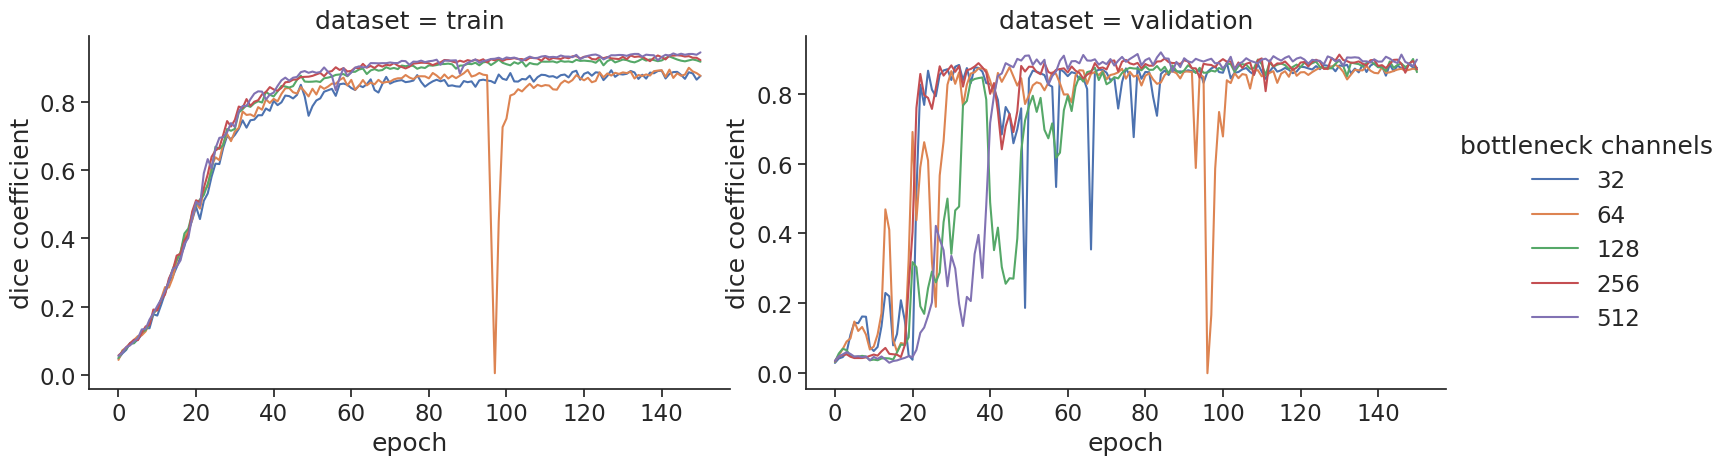

In [20]:
sns.set(font_scale=1.5)
sns.set_style("ticks")
rel = sns.relplot(
    data=data_pdf,
    x="epoch",
    y="value",
    hue="bottleneck channels",
    col="dataset",
    col_order=["train", "validation"],
    kind="line",
    palette="deep",
    aspect=1.5,
    facet_kws={"sharey": False}
)
rel.set(ylabel="dice coefficient")
leg = rel._legend
rel.fig

In [21]:
rel.savefig(figures_dir / "bottlneck_vanilla_unet.svg", dpi=300)

## Bottleneck unet without residuals

In [22]:
data_pdf = read_neptune_data(figures_dir / "bottleneck_unet_without_residuals")

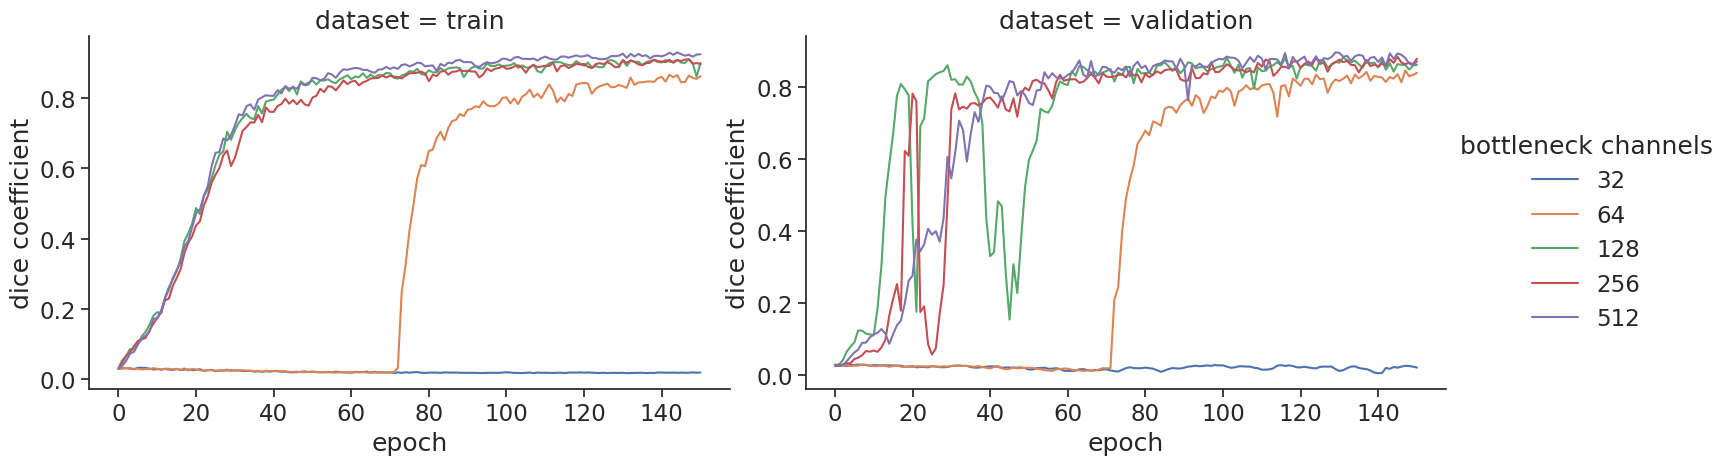

In [23]:
rel = sns.relplot(
    data=data_pdf,
    x="epoch",
    y="value",
    hue="bottleneck channels",
    col="dataset",
    col_order=["train", "validation"],
    kind="line",
    palette="deep",
    aspect=1.5,
    facet_kws={"sharey": False}
)
rel.set(ylabel="dice coefficient")
leg = rel._legend
rel.fig

In [24]:
rel.savefig(figures_dir / "bottlneck_no_residual_unet.svg", dpi=300)

# Dataset samples

In [3]:
class ImageMaskRandomDataset(Sequence):

    def __init__(
        self,
        image_dir: Union[str, Path],
        man_mask_dir: Union[str, Path],
        weak_mask_dir: Union[str, Path],
        transform: Transform = None,
        batch_size: int = 50,
        epoch_size: int = 1000,
        seed: Union[None, int, np.random.Generator] = None,
        thresh_obj_perc: float = 0.001,
        max_iters: int = 10,
        **kwargs,
    ) -> None:
        """ Initializes the dataset.

        Args:
            img_dir (Union[str, Path]): Directory containing images to use.
            transform (Transform, optional): Albumentations transforms to apply to images.
            batch_size (int, optional): Size of each batch. Defaults to 50.
            epoch_size (int, optional): Total number of samples in each epoch. Defaults to 1000.
        """
        super().__init__(**kwargs)
        self._rng = np.random.default_rng(seed)

        self._img_list = np.sort([
            path for path in Path(image_dir).rglob("*.tif")
            if not path.stem.startswith(".")
        ])

        self._man_mask_list = np.sort([
            path for path in Path(man_mask_dir).rglob("*.tif")
            if not path.stem.startswith(".")
        ])

        self._weak_mask_list = np.sort([
            path for path in Path(weak_mask_dir).rglob("*.tif")
            if not path.stem.startswith(".")
        ])


        self._transform = transform

        self.image_names = [img.name for img in self._img_list]
        self.man_mask_names = [mask.name for mask in self._man_mask_list]
        self.weak_mask_names = [mask.name for mask in self._weak_mask_list]

        assert np.all(self.man_mask_names == self.weak_mask_names)

        self._threshold_obj_perc = thresh_obj_perc
        self._max_iters = max_iters

        self.batch_size = batch_size
        self.epoch_size = epoch_size

    def _check_threshhold_condition(self, masks: np.ndarray) -> bool:
        """ Given a batch of masks, checks if they satisfy the condition of ROI density
        """
        num_positive = np.sum(masks.astype(bool))
        num_pixels = np.prod(masks.shape)

        return (num_positive / num_pixels) > self._threshold_obj_perc


    def _generate_data(self, batch_indices: Iterable[int]) -> np.ndarray:
        """ Given indices of masks, generates a batch of samples from them

        Args:
            batch_indices (Iterable[int]): Indices of masks to be included in the batch

        Returns:
            tuple[np.ndarray, np.ndarray]: Tuple of arrays representing masks
        """
        imgs = []
        man_masks = []
        weak_masks = []
        for idx in batch_indices:
            img = load_img(self._img_list[idx], color_mode="grayscale")
            img = np.expand_dims(img, -1)
            
            man_mask = load_img(self._man_mask_list[idx], color_mode="grayscale")
            man_mask = np.expand_dims(man_mask, -1)

            weak_mask = load_img(self._weak_mask_list[idx], color_mode="grayscale")
            weak_mask = np.expand_dims(weak_mask, -1)

            if self._transform is not None:
                transformed = self._transform(
                    image=img,
                    man_mask=man_mask,
                    weak_mask=weak_mask,
                )
                img = transformed["image"]
                man_mask = transformed["man_mask"]
                weak_mask = transformed["weak_mask"]

            imgs.append(img)
            man_masks.append(man_mask)
            weak_masks.append(weak_mask)

        return (np.stack(imgs),
                np.stack(man_masks).astype(bool),
                np.stack(weak_masks).astype(bool))

    def __len__(self) -> int:
        return int(np.ceil(self.epoch_size / self.batch_size))

    def __getitem__(self, index: int) -> np.ndarray:
        """ Generates a random batch of masks.

            Index argument is not used, it is only an argument because Sequence requires it.
        """
        for _ in range(self._max_iters):
            batch_indices = self._rng.choice(len(self._man_mask_list), size=self.batch_size, replace=True)
            imgs, man_masks, weak_masks = self._generate_data(batch_indices)
            if self._check_threshhold_condition(man_masks):
                break

        return imgs.astype(np.float32), man_masks.astype(np.float32), weak_masks.astype(np.float32)


In [4]:
DATA_ROOT = Path("../data/local/validation/")
IMG_DIR = DATA_ROOT / "img"
MAN_MASK_DIR = DATA_ROOT / "man_mask"
WEAK_MASK_DIR = DATA_ROOT / "weak_mask"

transform = Compose(
    [
        ToFloat(max_value=255),
        Affine(scale=0.5, fit_output=True, keep_ratio=True, p=1),
#        RandomCrop(width=256, height=256),
    ],
    additional_targets={
        "man_mask": "mask",
        "weak_mask": "mask",
    }
)

mask_dataset = ImageMaskRandomDataset(
    IMG_DIR,
    MAN_MASK_DIR,
    WEAK_MASK_DIR,
    transform=transform,
    batch_size=1,
    epoch_size=1,
)

In [11]:
from src.data.image_mask_datasets import ImageMaskDataset
from src.models.metrics import dice_coeff

In [10]:
man_mask_dataset = ImageMaskDataset(
    IMG_DIR,
    MAN_MASK_DIR,
    transform=None,
    batch_size=1,
)
weak_mask_dataset = ImageMaskDataset(
    IMG_DIR,
    WEAK_MASK_DIR,
    transform=None,
    batch_size=1,
)

In [18]:
dice = []
for (_, man_mask), (_, weak_mask) in zip(man_mask_dataset, weak_mask_dataset):
    dice.append(dice_coeff(man_mask, weak_mask).numpy())
print(np.mean(dice))

0.58062166


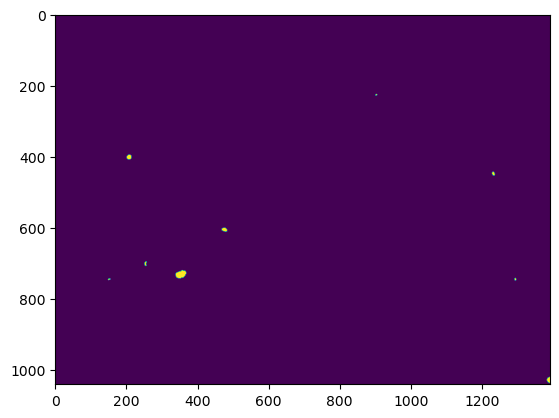

In [16]:
plt.imshow(np.squeeze(man_mask))

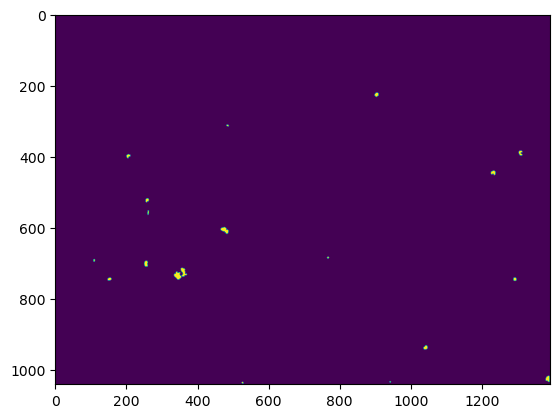

In [17]:
plt.imshow(np.squeeze(weak_mask))

In [5]:
def plot_sample(img, man_mask, weak_mask):
    fig, axes= plt.subplots(1, 3, figsize=(15, 5))
    man_mask = np.ma.masked_where(man_mask == 0, man_mask)
    weak_mask = np.ma.masked_where(weak_mask == 0, weak_mask)
    for ax in axes:
        ax.axis('off')
        ax.imshow(img, cmap="gray")
    axes[1].imshow(man_mask, alpha=0.8)
    axes[2].imshow(weak_mask, alpha=0.8)
    plt.tight_layout()
    fig.show()
    return fig

/tmp/ipykernel_5298/4050730879.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


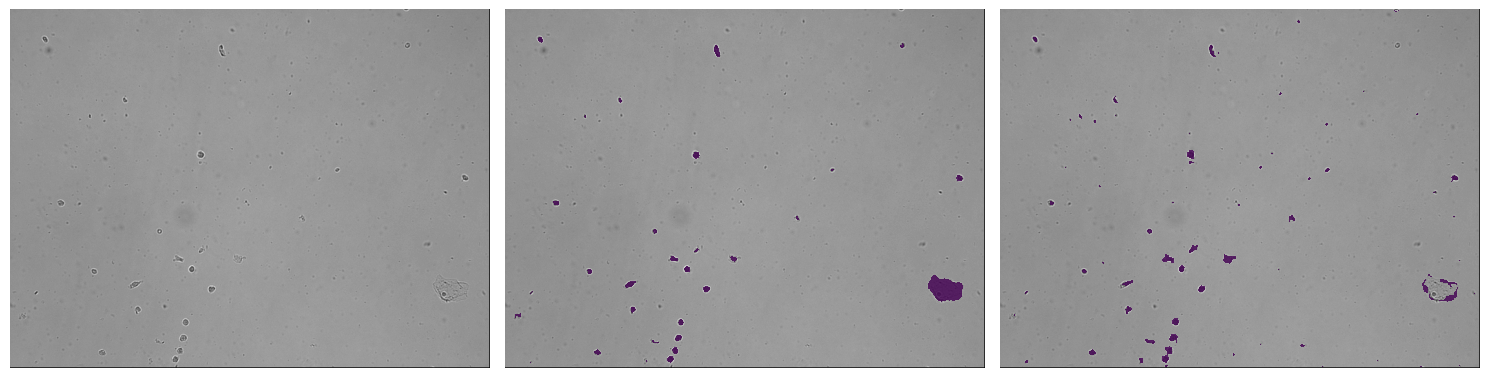

In [23]:
img, man_mask, weak_mask = np.squeeze(mask_dataset[0])
fig = plot_sample(img, man_mask, weak_mask)

In [24]:
fig.savefig(figures_dir / "masks_comparison" / "2.svg", dpi=300)

# Experiments averaged

In [4]:
def read_finetune_runs(dir):
    pdfs = []
    for file in (dir).iterdir():
        dataset = file.name.partition('_')[0]
        with ZipFile(file) as train_zip:
            for idx, name in enumerate(train_zip.namelist()):
                with train_zip.open(name, 'r') as file:
                    pdf = pd.read_csv(
                        BytesIO(file.read()),
                        index_col=0,
                        names=["epoch", "time", "value"],
                    )
                    pdf["dataset"] = dataset
                    pdf["num"] = idx
                    pdfs.append(pdf)

    data_pdf = pd.concat(pdfs).reset_index()
    data_pdf = data_pdf.astype({
        "epoch": int,
        "time": int,
        "value": float,
    })
    return data_pdf

In [5]:
data = []
for task in ["thresholding", "ilastik", "region_duplication", "standard_deviation", "autoencoder"]:
    data_pdf = read_finetune_runs(figures_dir / task)
    data_pdf["approach"] = task
    data.append(data_pdf)
    
data_pdf = pd.concat(data)

In [67]:
sns.set(font_scale=1.5)
sns.set_style("ticks")

facet_grid = sns.relplot(
    data=data_pdf,
    x="epoch",
    y="value",
    row="approach",
    col="dataset",
    col_order=["train", "validation"],
    kind="line",
    palette="deep",
    aspect=1.5,
    facet_kws={"sharey": False, "sharex": False},
    ci="sd"
    )

facet_grid.set(ylim=(0, 1), xlim=(0, 200), ylabel="dice coefficient")

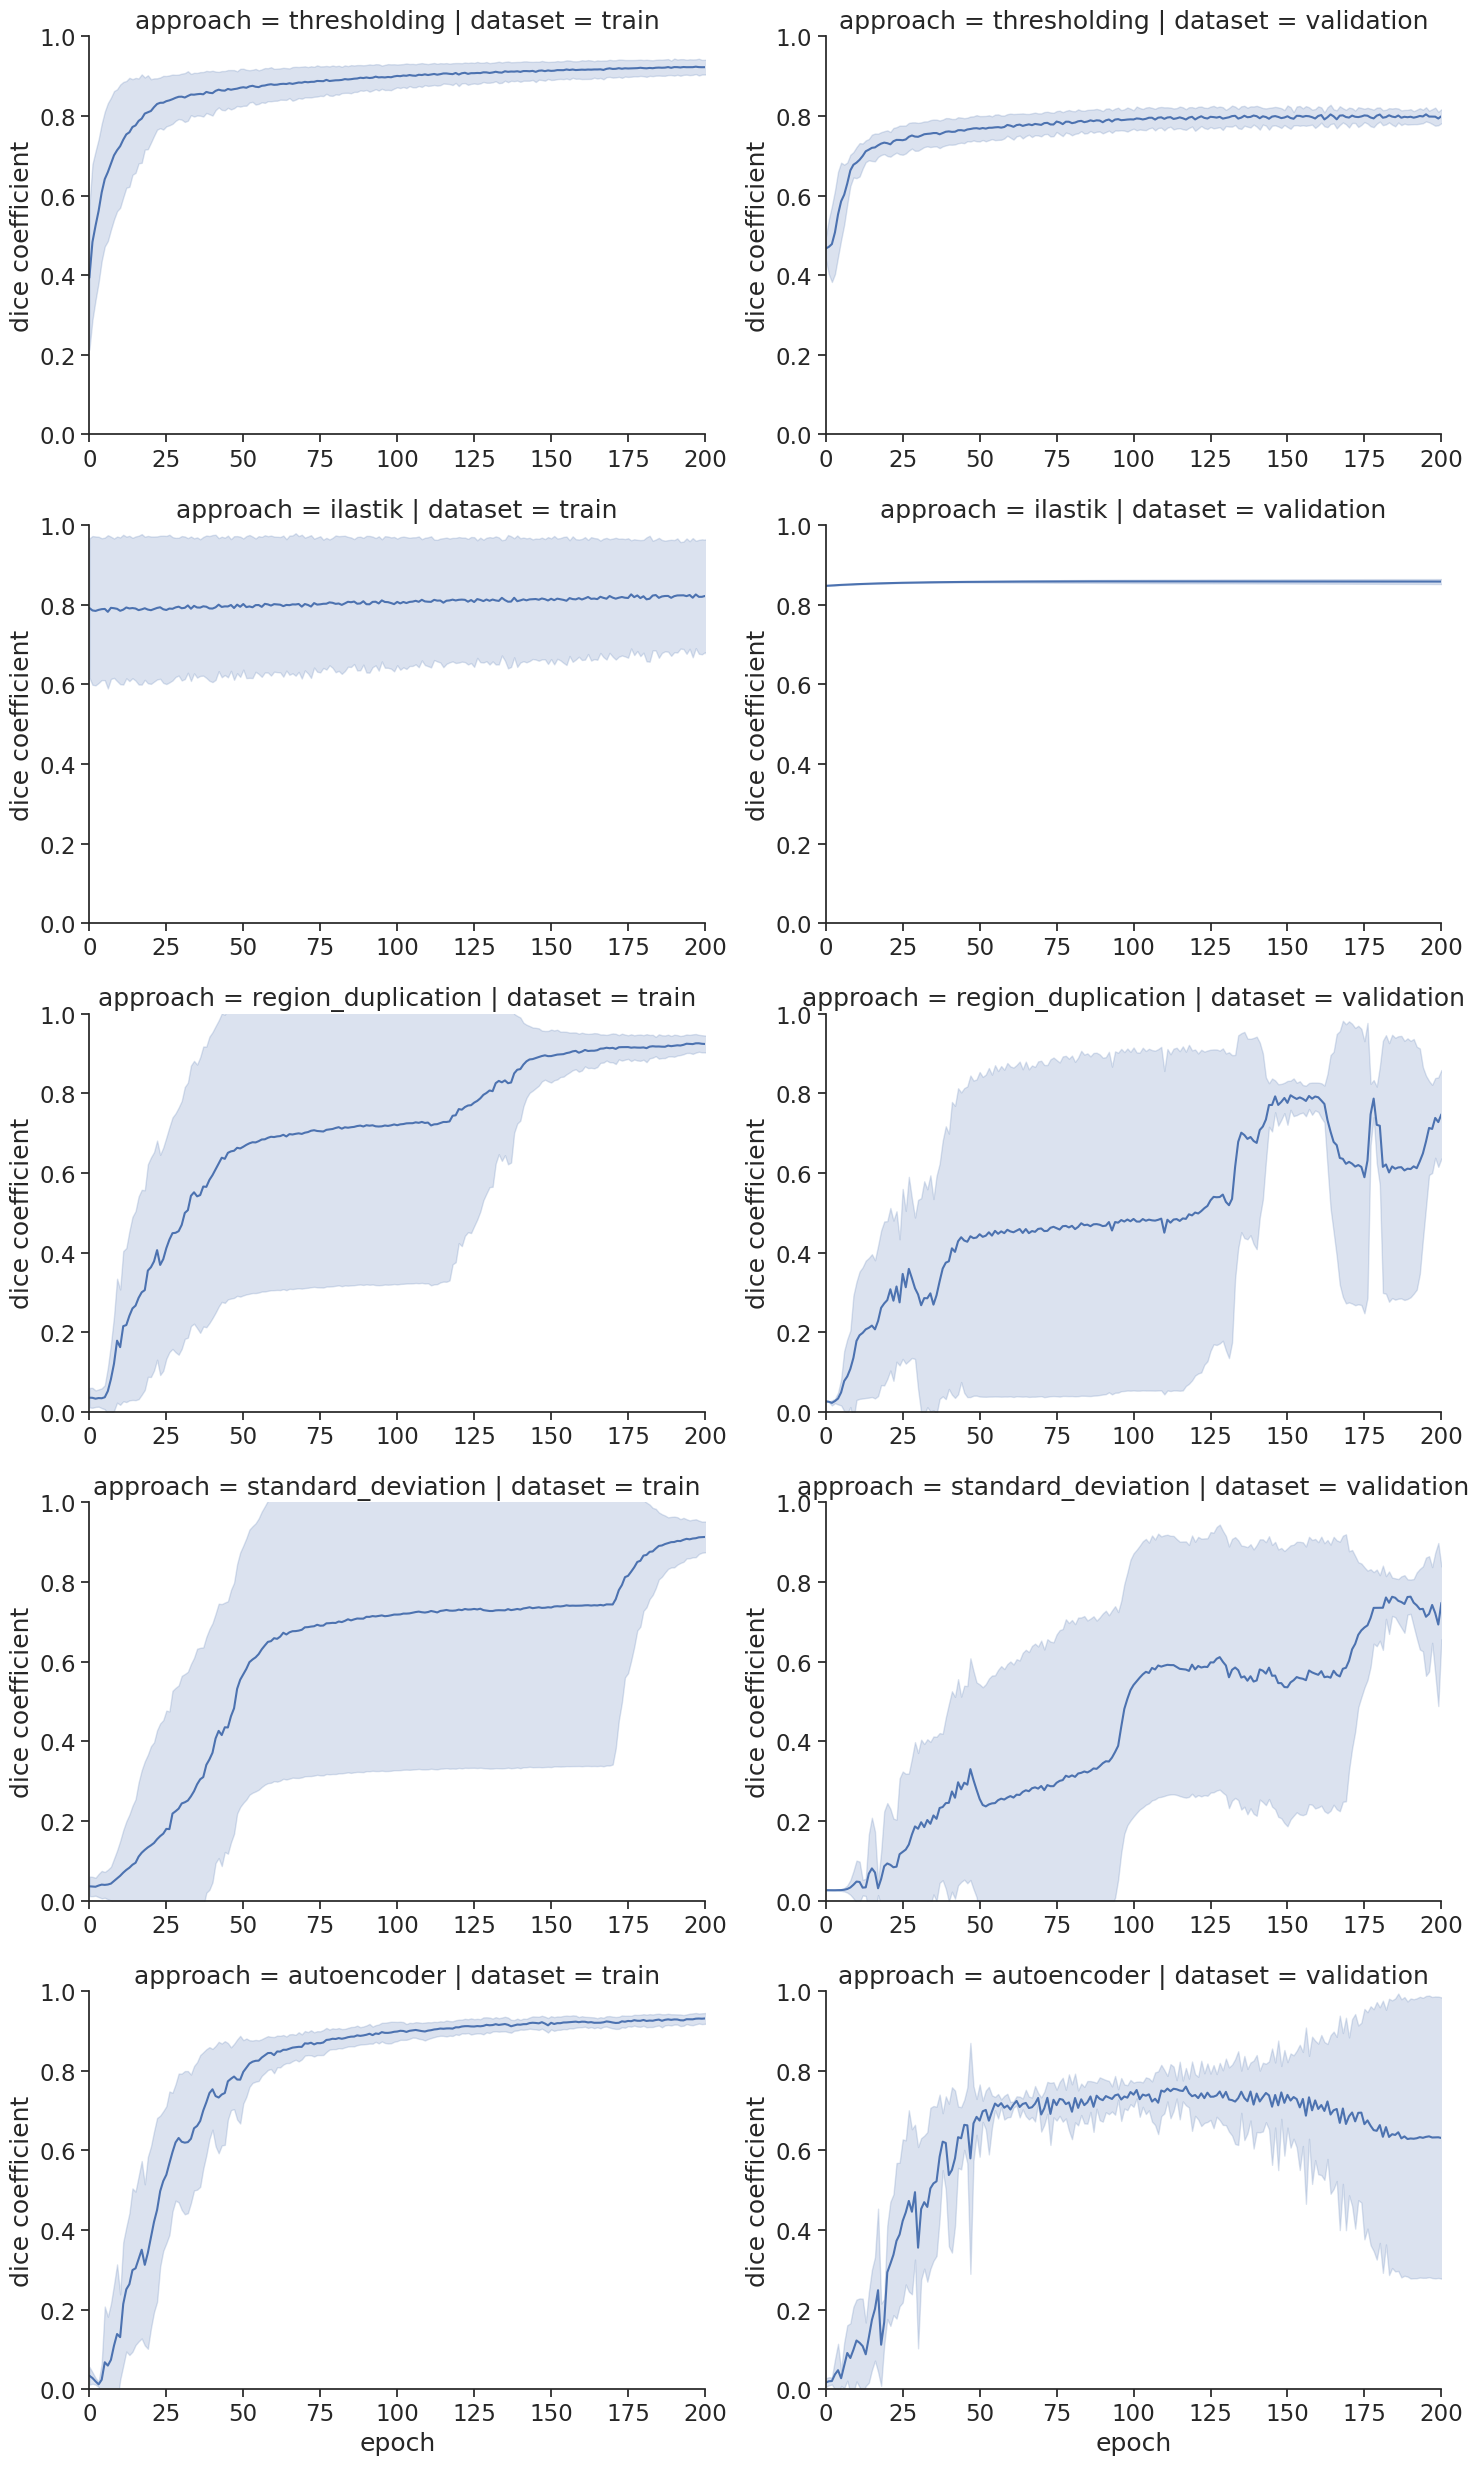

In [68]:
plt.show()

In [41]:
facet_grid.savefig(figures_dir / "pretext_training.svg", dpi=300)

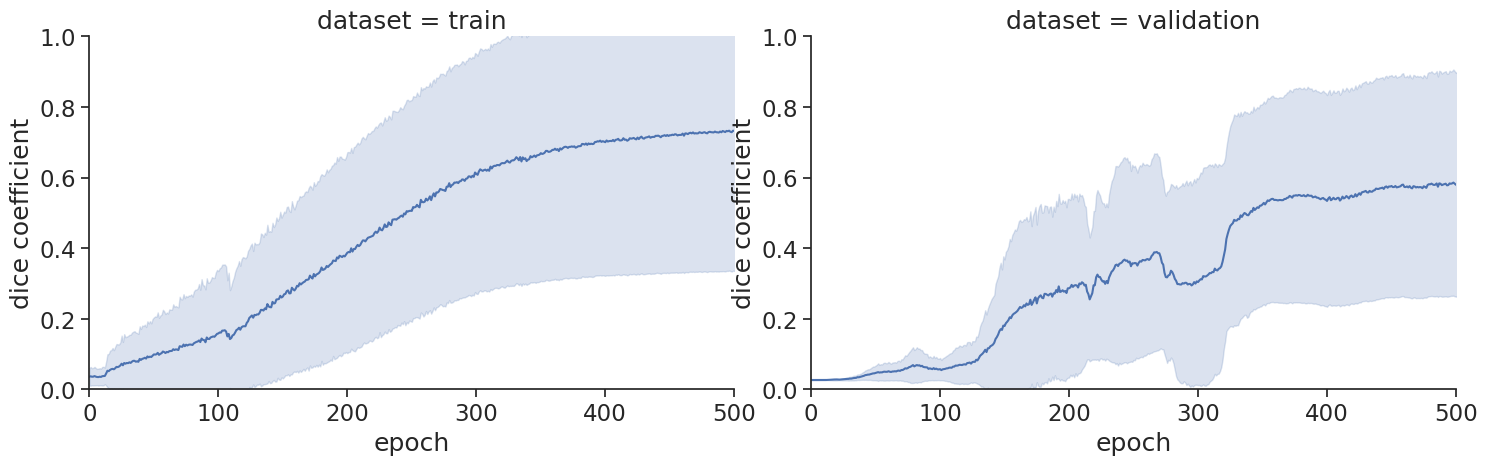

In [7]:
data_pdf = read_finetune_runs(figures_dir / "supervised")

sns.set(font_scale=1.5)
sns.set_style("ticks")

facet_grid = sns.relplot(
    data=data_pdf,
    x="epoch",
    y="value",
    col="dataset",
    col_order=["train", "validation"],
    kind="line",
    palette="deep",
    aspect=1.5,
    facet_kws={"sharey": False, "sharex": False},
    ci="sd"
    )

facet_grid.set(ylim=(0, 1), xlim=(0, 500), ylabel="dice coefficient")
plt.show()


In [8]:

facet_grid.savefig(figures_dir / "supervised.svg", dpi=300)

## Instance normalization


In [15]:
file = figures_dir / "instance_normalization" / "comparison.zip"
pdfs = []
with ZipFile(file) as train_zip:
    for name in train_zip.namelist():
        with train_zip.open(name, 'r') as file:
            pdf = pd.read_csv(
                BytesIO(file.read()),
                names=["epoch", "time", "value"],
            )
            if '265' in name:
                pdf['instance_normalization'] = True
            elif '182' in name:
                pdf['instance_normalization'] = False
            else:
                raise ValueError()
            pdfs.append(pdf)
data_pdf = pd.concat(pdfs).astype({
    "epoch": int,
    "time": int,
    "value": float,
})

In [18]:
data_pdf

,epoch,time,value,instance_normalization
0,0,1681723545199,0.028334,True
1,1,1681723601487,0.024920,True
2,2,1681723660859,0.030348,True
3,3,1681723719427,0.030863,True
4,4,1681723775645,0.029047,True
...,...,...,...,...
745,745,1676638633020,0.817206,False
746,746,1676638651209,0.116939,False
747,747,1676638672597,0.032060,False
748,748,1676638693712,0.857096,False


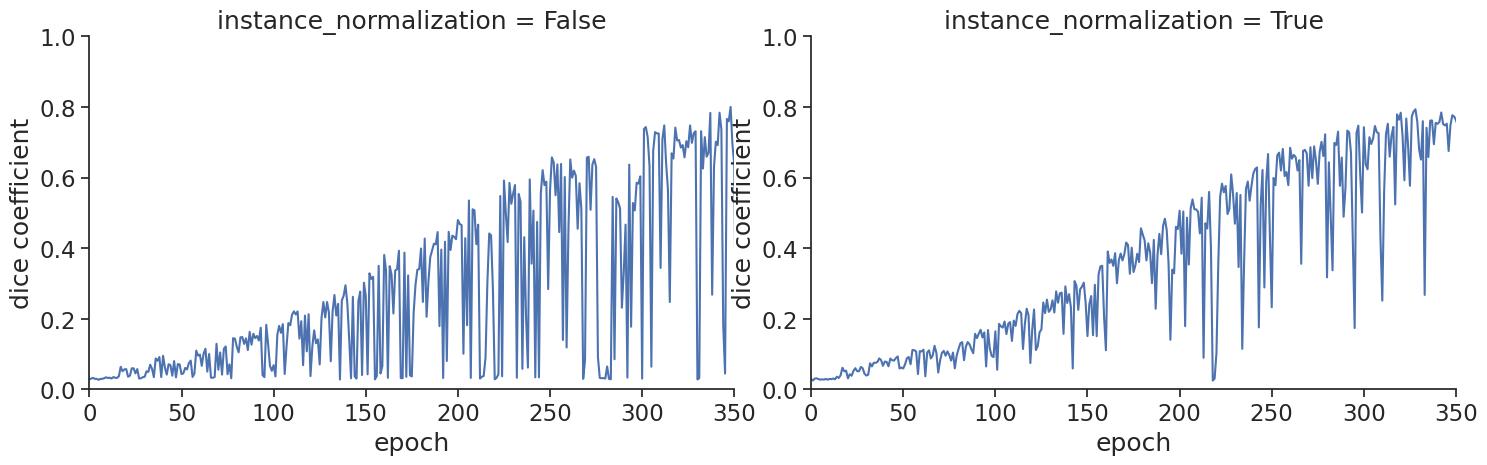

In [46]:
sns.set(font_scale=1.5)
sns.set_style('ticks')
facet_grid = sns.relplot(
    data=data_pdf,
    x="epoch",
    y="value",
    col="instance_normalization",
    kind="line",
    palette="deep",
    aspect=1.5,
    facet_kws={"sharey": False}
    )
facet_grid.set(ylim=(0, 1), xlim=(0,350), ylabel="dice coefficient")
plt.show()

In [47]:
facet_grid.savefig(figures_dir / "instance_normalization" / "instance_normalization.svg", dpi=300)